In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate

import torch
import torch.nn as nn
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.float32

$\frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}$

$u(x,0) = \sin (\pi x)$

$u(x,t) = e^{-\kappa \pi^2 t}\sin(\pi x)$

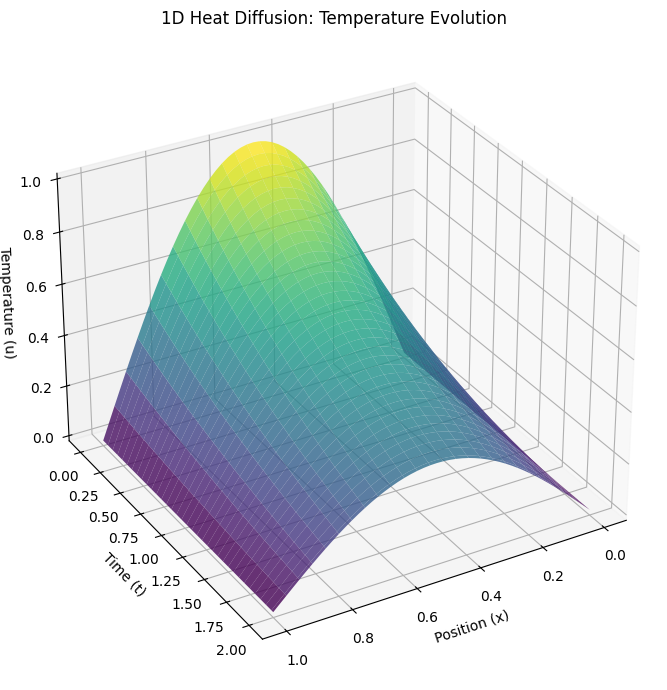

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Parameters
L = 1.0        # Length of the physical domain
T = 2.0         # Total time
Nx = 50        # Number of spatial points
Nt = 100      # Number of time steps
alpha = 0.05   # Thermal diffusivity
dx = L / Nx    # Spatial step size
dt = T / Nt    # Time step size

# Discretize the spatial and time domain
t = np.linspace(0, T, Nt+1)  # Time grid
x = np.linspace(0, L, Nx+1)  # Spatial grid

# Initialize temperature array
u = np.zeros((Nt+1, Nx+1))   # u[n, i] corresponds to time step n and position i

# Initial condition: u(0,x) = sin(pi * x)
u[0, :] = np.sin(np.pi * x)

for n in range(1, Nt+1):
    # Analytical solution for the current time step
    u[n, :] = np.exp(-alpha * (np.pi**2) * t[n]) * np.sin(np.pi * x)

# Create a meshgrid for position and time
xx, tt = np.meshgrid(x, t)


# Create the surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
surf = ax.plot_surface(xx, tt, u, cmap='viridis', alpha=0.8)

# Rotate the plot by setting elevation and azimuth
ax.view_init(elev=30, azim=60)  # Elevation and azimuth angles

# Labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Temperature (u)')
ax.set_title('1D Heat Diffusion: Temperature Evolution')

# Adjust layout to avoid cutting off the z-axis label
plt.tight_layout()  # Automatically adjust the layout

# Show plot
plt.show()


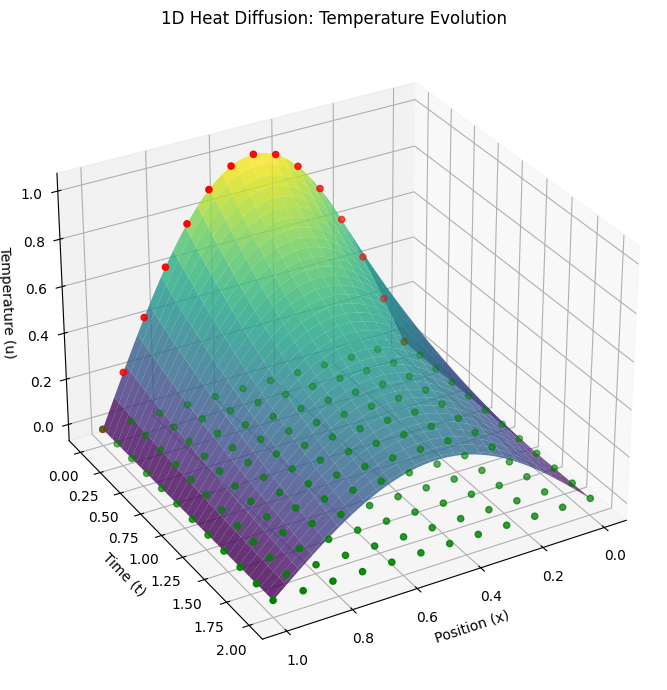

In [82]:
# Sample training data at t=0
N_train = 15
train_x = np.linspace(0, L, N_train)
train_t = np.zeros_like(train_x)
train_u = np.sin(np.pi * train_x)

# train_u += 0.01*np.random.randn(*train_u.shape)  # emulate measurement noise

training_data = np.hstack(( np.expand_dims(train_t,-1), np.expand_dims(train_x,-1),np.expand_dims(train_u,-1)))

# Sample collocation points
N_COLLOCATION_POINTS = 12
xx_colloc, tt_colloc = np.meshgrid(np.linspace(0,L,N_COLLOCATION_POINTS), np.linspace(0,T,N_COLLOCATION_POINTS))
collocation_pts = torch.tensor(np.hstack((tt_colloc.reshape(-1,1), xx_colloc.reshape(-1,1))), dtype=dtype).requires_grad_(True)

# Create the surface plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d',computed_zorder=False)
surf = ax.plot_surface(xx, tt, u, cmap='viridis', alpha=0.8)
ax.scatter(train_x, train_t, train_u, color='red')
ax.scatter(xx_colloc, tt_colloc, np.zeros_like(tt_colloc), color='green')

# Rotate the plot by setting elevation and azimuth
ax.view_init(elev=30, azim=60)  # Elevation and azimuth angles

# Labels and title
ax.set_xlabel('Position (x)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Temperature (u)')
ax.set_title('1D Heat Diffusion: Temperature Evolution')

# Adjust layout to avoid cutting off the z-axis label
plt.tight_layout()  # Automatically adjust the layout

# Show plot
plt.show()

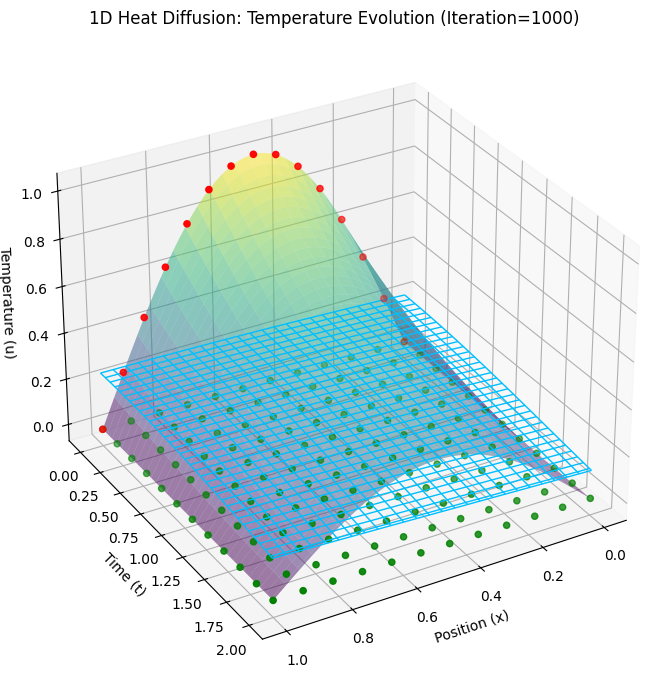

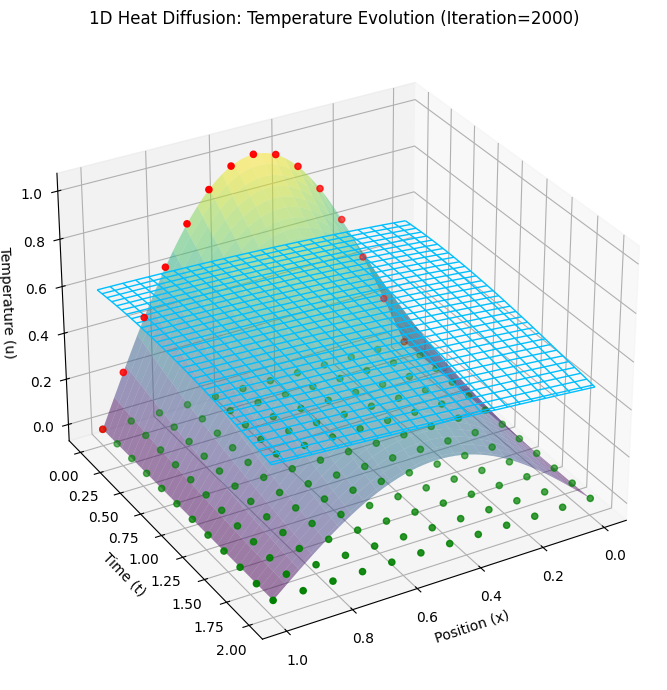

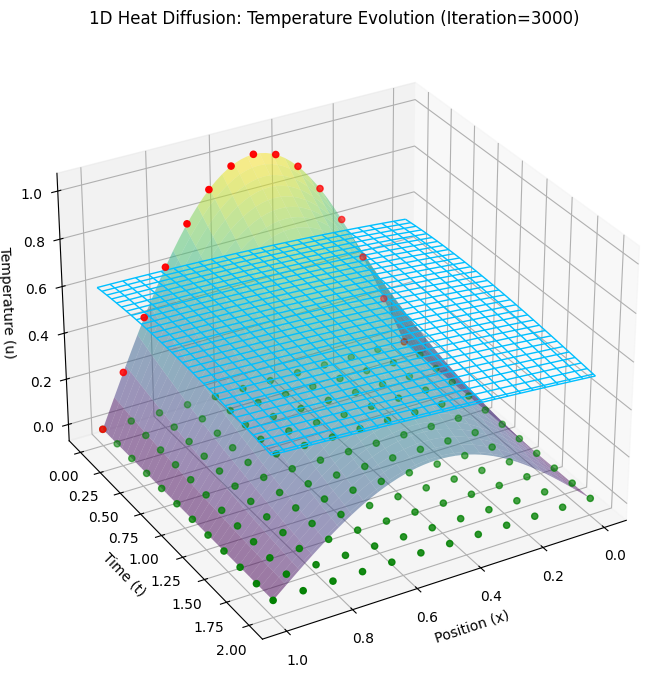

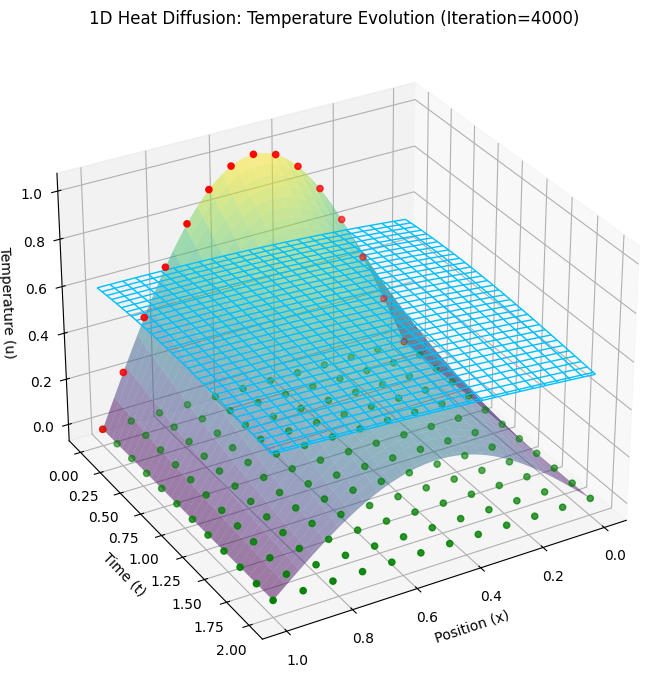

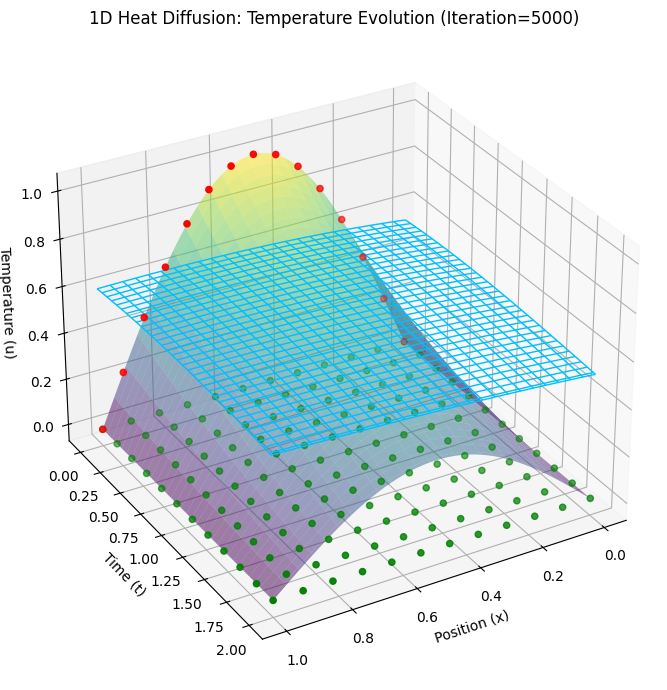

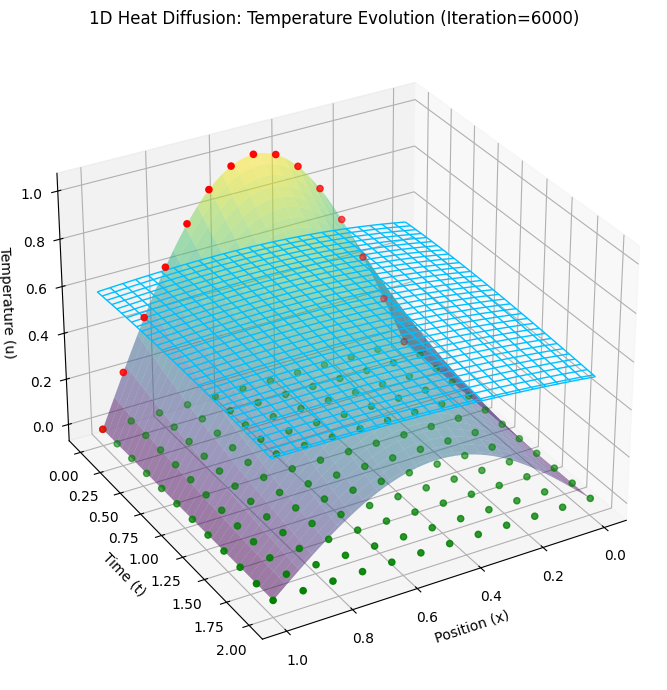

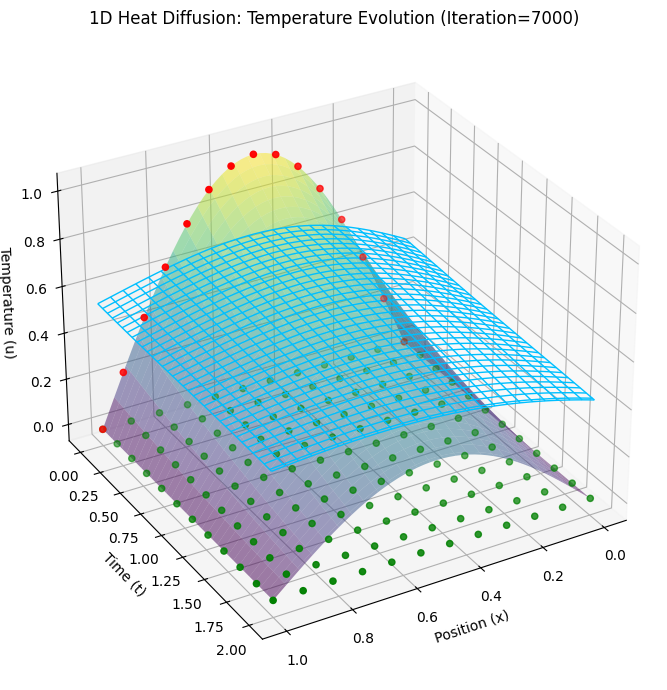

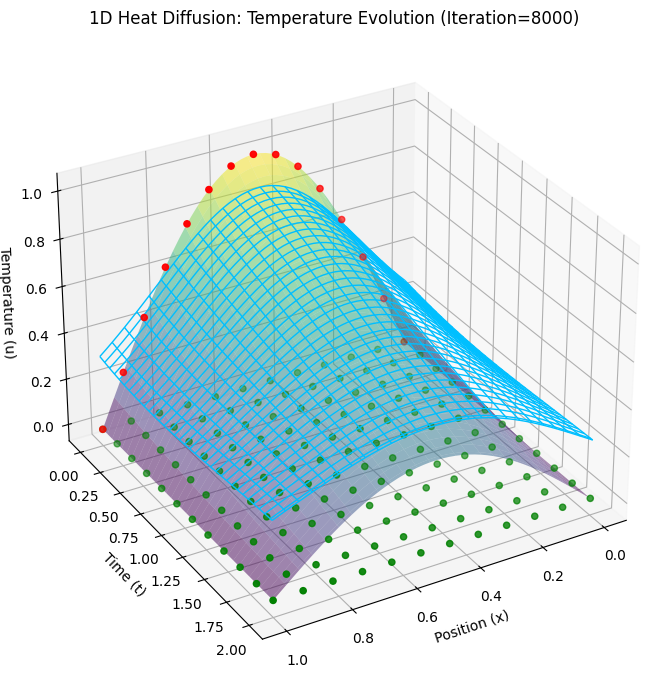

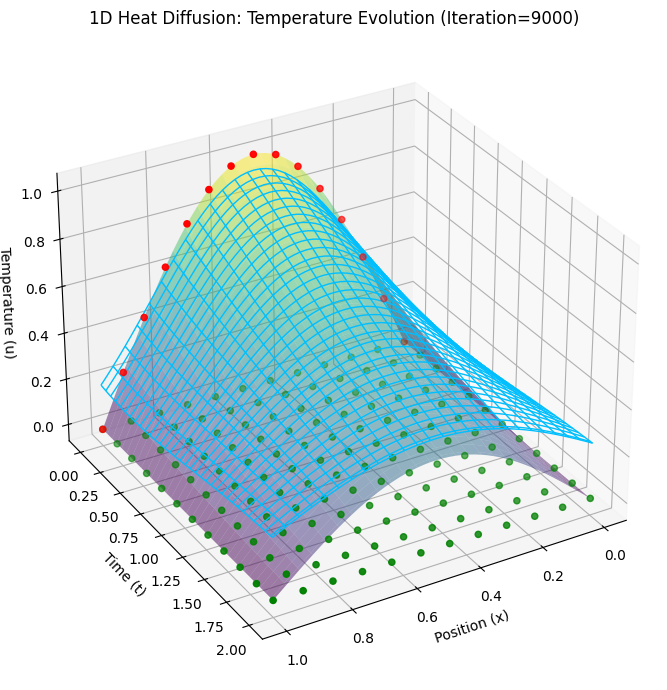

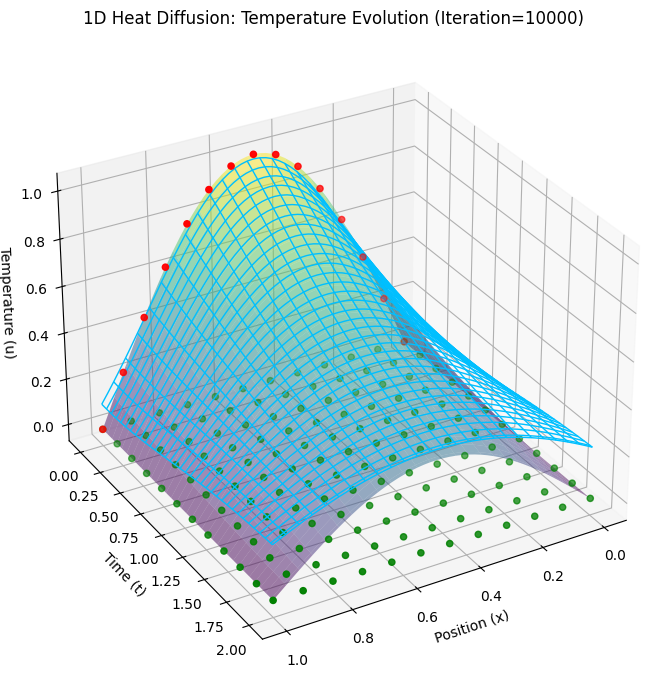

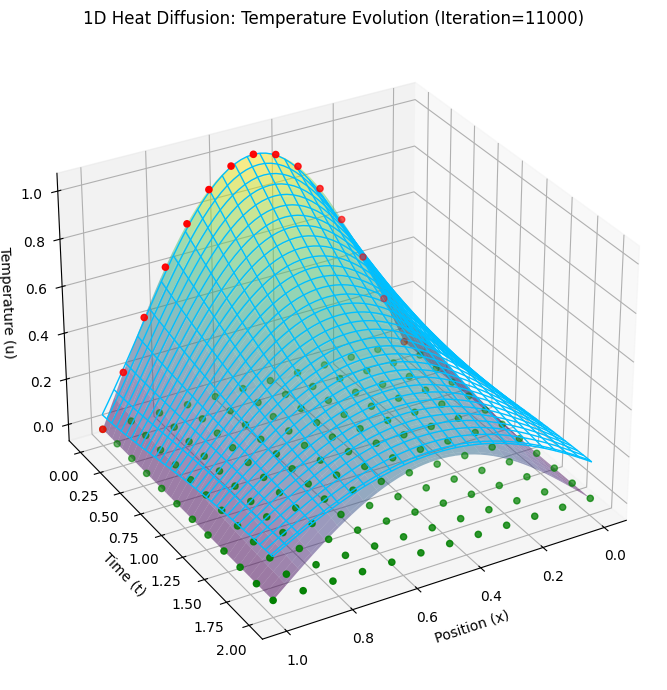

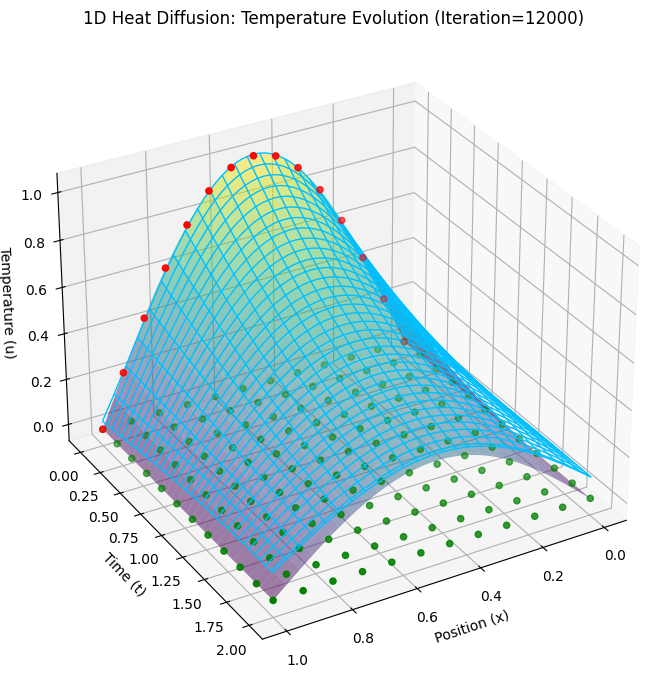

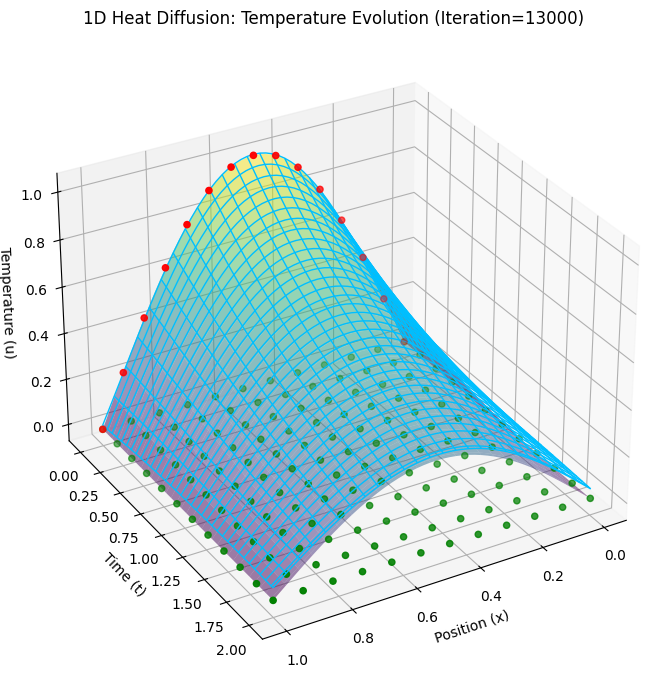

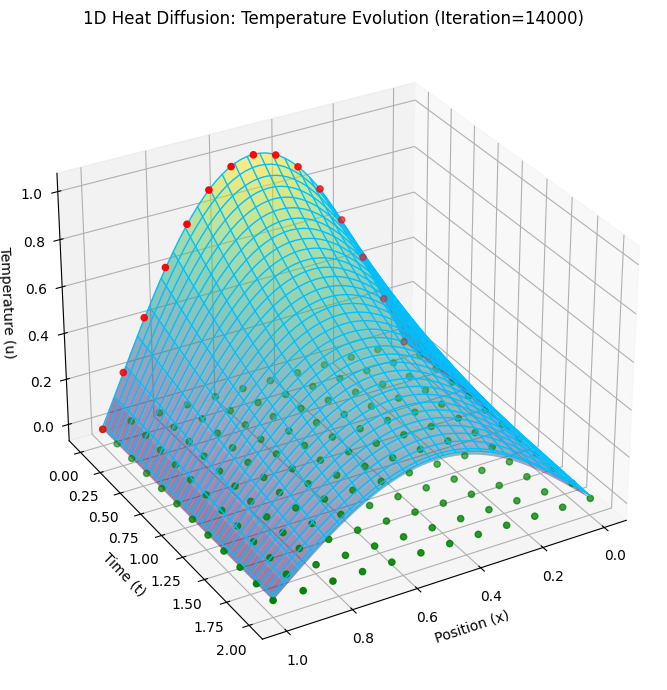

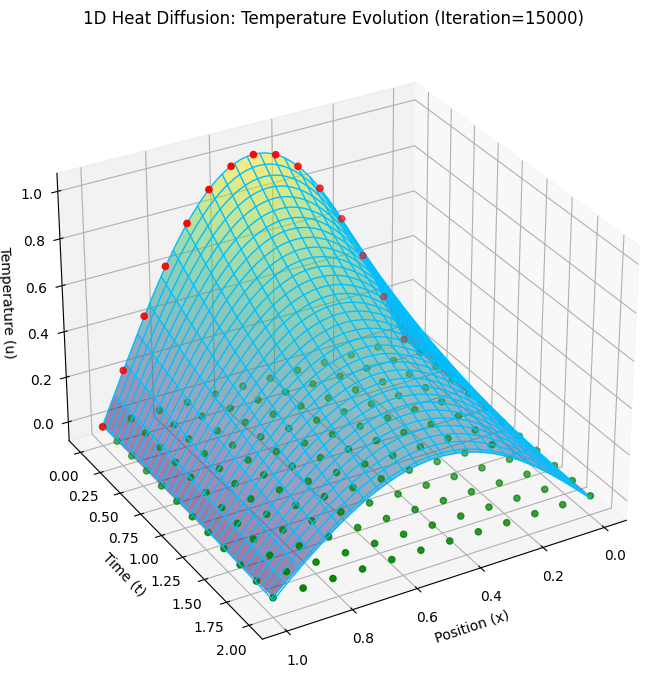

In [84]:
class Backbone(nn.Module):
    def __init__(self, dtype=torch.float32):
        super().__init__()

        self.fc1 = nn.Linear(2, 32, dtype=dtype)  # input dim = 2 (t,x)
        self.fc2 = nn.Linear(32, 32, dtype=dtype)  # hidden dims = 512, 512, 512
        self.fc3 = nn.Linear(32, 32, dtype=dtype)  #
        self.fc4 = nn.Linear(32, 32, dtype=dtype)  #
        self.fc5 = nn.Linear(32, 32, dtype=dtype)  #
        self.fc6 = nn.Linear(32, 32, dtype=dtype)  #
        self.out = nn.Linear(32, 1, dtype=dtype)  # output dim = 1 (u)

        self.dtype = dtype

    def forward(self, x):
        x = self.fc1(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x)
        x = self.fc2(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x)
        x = self.fc3(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x)
        x = self.fc4(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x)
        x = self.fc5(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x)
        x = self.fc6(x)
        x = nn.Tanh()(x) 
        # x = nn.SiLU()(x) 
        return self.out(x)
    
model = Backbone()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
files = []
import os
save_dir = 'results/heat1d'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
MAX_ITER = 15000
for iter in range(MAX_ITER):
    optimizer.zero_grad()
    input = torch.tensor(training_data[:,:2], dtype=model.dtype)
    output = torch.tensor(training_data[:,2:], dtype=model.dtype)
    prediction = model(input)
    data_loss = torch.mean((output-prediction)**2)
    
    prediction_colloc = model(collocation_pts)
    # deriv = torch.autograd.grad(prediction_colloc, collocation_pts, torch.ones_like(prediction_colloc), retain_graph=True, create_graph=True)[0]
    deriv = torch.autograd.grad(prediction_colloc, collocation_pts, torch.ones_like(prediction_colloc), retain_graph=True, create_graph=True)[0]
    dt = deriv[:,0]
    dx = deriv[:,1]
    deriv2 = torch.autograd.grad(dx, collocation_pts, torch.ones_like(dx), create_graph=True)[0]
    ddx = deriv2[:,1]
    physics_loss = torch.mean((dt-alpha*ddx)**2)

    loss = data_loss + physics_loss
    loss.backward()
    optimizer.step()

    print(f"{iter+1}/{MAX_ITER} - loss: {loss.detach().numpy():.5e}, physics: {physics_loss.detach().numpy():.5e}", end='\r')
    
    # plot the result as training progresses
    if (iter+1) % 100 == 0: 
        
        prediction = model(torch.tensor(np.hstack((tt.reshape(-1,1),xx.reshape(-1,1))), dtype=model.dtype)).detach()

        # Create the surface plot
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d',computed_zorder=False)

        # Plot the surface
        surf = ax.plot_surface(xx, tt, u, cmap='viridis', alpha=0.5, zorder=1)
        wire = ax.plot_wireframe(xx, tt, prediction.reshape(xx.shape), color='deepskyblue', linewidth=1, zorder=2)
        ax.scatter(train_x, train_t, train_u, color='red', zorder=99)
        ax.scatter(xx_colloc, tt_colloc, np.zeros_like(tt_colloc), color='green')

        # Rotate the plot by setting elevation and azimuth
        ax.view_init(elev=30, azim=60)  # Elevation and azimuth angles

        # Labels and title
        ax.set_xlabel('Position (x)')
        ax.set_ylabel('Time (t)')
        ax.set_zlabel('Temperature (u)')
        ax.set_title(f'1D Heat Diffusion: Temperature Evolution (Iteration={iter+1})')

        # Adjust layout to avoid cutting off the z-axis label
        plt.tight_layout()  # Automatically adjust the layout

        
        file = os.path.join(save_dir, "pinn_%.6i.png"%(iter+1))
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (iter+1) % 1000 == 0: plt.show()
        else: plt.close("all")

from PIL import Image
fps = 20
imgs = [Image.open(file) for file in files]
imgs[0].save(fp="results/pinn_heat.gif", format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=True)
